In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

In [105]:
from experiments import BasicSetup
from experiments import utilities as utils
from bayesinverse import Regression

In [106]:
config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/basic_setup/config.yaml"
)

exp = BasicSetup(config_path)
# basic_setup.run()


sensors 0.0030305683612823486
emissions 5.863433450460434
transport 10.120937332510948


### Get absolute values for K, x, and x_prior

In [107]:
# Get relative value for K
exp.K = exp.transport.get_transport(
    exp.sensors.n_sensors, exp.sensors.get_index(), exp.emissions, n_processes=20,
)


loop start 17.151270747184753
loop end 17.1907866448164


In [108]:
# Convert K to absolute values
absolute_emissions = exp.emissions.get_absolute()
K_abs = exp.K / absolute_emissions

In [109]:
exp.emissions.prior_absolute
exp.emissions.prior_absolute_covariance = exp.emissions.prior_covariance * absolute_emissions**2

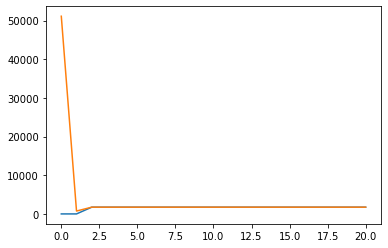

In [110]:
plt.plot(exp.emissions.prior_absolute)
plt.plot(np.sqrt(exp.emissions.prior_absolute_covariance))


In [111]:
noise = exp.sensors.get_noise()
exp.reg = Regression(
    y=utils.stack_xr(
        exp.K @ exp.emissions.truth
        + noise
    ).values,
    K=utils.stack_xr(exp.K).values,
    x_prior=utils.stack_xr(exp.emissions.prior).values,
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
    y_covariance=utils.stack_xr(
        exp.sensors.get_covariance()
    ).values,
)
x_est, res, rank, s = exp.reg.fit()
posterior = exp.emissions.to_xr(x_est)

exp.reg_absolute = Regression(
    y=utils.stack_xr(
        K_abs @ exp.emissions.truth_absolute
        + noise
    ).values,
    K=utils.stack_xr(K_abs).values,
    x_prior=utils.stack_xr(exp.emissions.prior_absolute).values,
    x_covariance=utils.stack_xr(exp.emissions.prior_absolute_covariance).values,
    y_covariance=utils.stack_xr(
        exp.sensors.get_covariance()
    ).values,
)
x_est, res, rank, s = exp.reg_absolute.fit()
posterior_absolute = exp.emissions.to_xr(x_est)



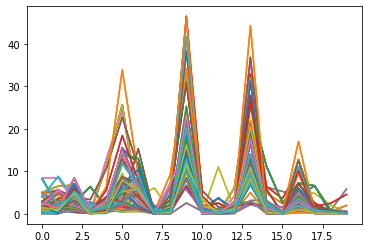

In [112]:
plt.plot((exp.K @ exp.emissions.truth))
plt.plot((K_abs @ exp.emissions.truth_absolute))

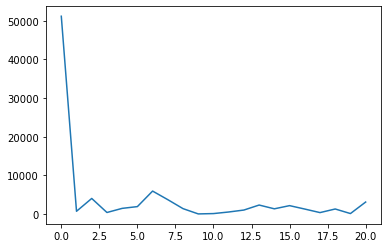

In [113]:
plt.plot(exp.emissions.truth_absolute)

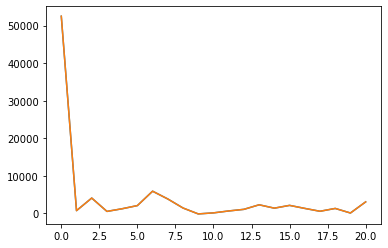

In [114]:
plt.plot(utils.stack_xr(utils.unstack_xr(posterior) * absolute_emissions))
plt.plot(posterior_absolute)

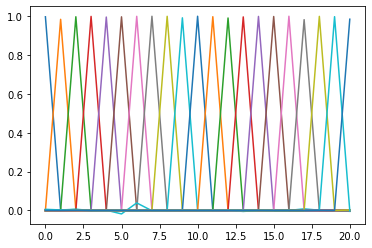

In [115]:
averaging_kernel = exp.reg.get_averaging_kernel()
for i in range(averaging_kernel.shape[0]):
    kernel = averaging_kernel[i]
    plt.plot(kernel, label=kernel.sum())
    # print(kernel.sum())
# plt.legend()

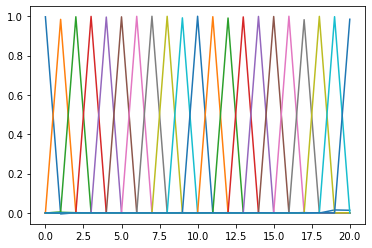

In [116]:
averaging_kernel = exp.reg_absolute.get_averaging_kernel()
for i in range(averaging_kernel.shape[0]):
    kernel = averaging_kernel[i]
    plt.plot(kernel, label=kernel.sum())
    # print(kernel.sum())
# plt.legend()


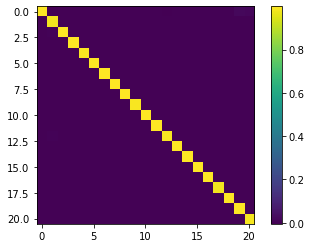

In [117]:
im = plt.imshow(
    exp.reg_absolute.get_averaging_kernel()
)
plt.colorbar(im)


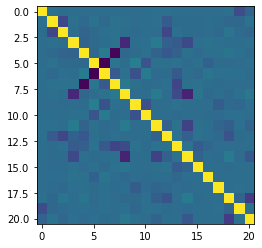

In [118]:
plt.imshow(exp.reg_absolute.get_correlation())

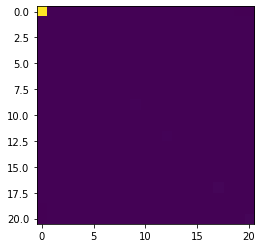

In [119]:
plt.imshow(
    exp.reg_absolute.get_posterior_covariance()
)


In [120]:
exp.reg.get_information_content(), exp.reg.get_dof_signal(), exp.reg.get_dof_noise()

(65.71251685400397, 20.904480229821708, 0.09551977017829129)

In [121]:
exp.reg_absolute.get_information_content(), exp.reg_absolute.get_dof_signal(), exp.reg_absolute.get_dof_noise()

(65.71251685400861, 20.904480229821704, 0.0955197701782913)